# WQD 7012 Applied Machine Learning Assignment

## Assignment Details

- Title: Optimizing Loan Approval Decisions with Machine Learning Models
- Date: April 8, 2025

## 1. Intial Setup

Import some of the useful libraries and load the data for usage in other section. If you haven't install any of the package, type this in the terminal for installation:

```bash
py -m pip install <package_name>

# if you have a few version of python in your system
py -3.10 -m pip install <package_name>
py -3.11 -m pip install <package_name>
py -3.12 -m pip install <package_name>
py -3.13 -m pip install <package_name>
```

In [106]:
# import libraries
import pandas as pd
import warnings 
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns

# turn off warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [107]:
# load and preview the data
df = pd.read_csv('data/data.csv')
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


## 2. Data Understanding

This section probably will include steps like showing the shape of the data, the summary statistics, counting the unique values, and checking the data types. The goal is to understand the data better before we start the analysis.


In [108]:
# check the shape of the data
print("The shape of the dataset is", df.shape[0], "rows and", df.shape[1], "columns.\n")

The shape of the dataset is 45000 rows and 14 columns.



In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [110]:
# Data types of each column
int_columns = df.select_dtypes(include='int64').columns.tolist()
float_columns = df.select_dtypes(include='float64').columns.tolist()
string_columns = df.select_dtypes(include='object').columns.tolist()

print("Integer columns:", int_columns)
print("Float columns:", float_columns)
print("String columns:", string_columns)

Integer columns: ['person_emp_exp', 'credit_score', 'loan_status']
Float columns: ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
String columns: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']


In [111]:
# Categorical columns summary - value distribution
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    print(f"\nColumn: {col}")
    print(df[col].value_counts())


Column: person_gender
person_gender
male      24841
female    20159
Name: count, dtype: int64

Column: person_education
person_education
Bachelor       13399
Associate      12028
High School    11972
Master          6980
Doctorate        621
Name: count, dtype: int64

Column: person_home_ownership
person_home_ownership
RENT        23443
MORTGAGE    18489
OWN          2951
OTHER         117
Name: count, dtype: int64

Column: loan_intent
loan_intent
EDUCATION            9153
MEDICAL              8548
VENTURE              7819
PERSONAL             7552
DEBTCONSOLIDATION    7145
HOMEIMPROVEMENT      4783
Name: count, dtype: int64

Column: previous_loan_defaults_on_file
previous_loan_defaults_on_file
Yes    22858
No     22142
Name: count, dtype: int64


In [112]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64


There are no missing values found in all columns

In [113]:
# Check for duplicate rows
duplicate_rows = df[df.duplicated()]
print(f"\nNumber of duplicate rows: {duplicate_rows.shape[0]}")

# Display duplicate rows if any
if not duplicate_rows.empty:
    display(duplicate_rows)
else:
    print("No duplicate rows found.")


Number of duplicate rows: 0
No duplicate rows found.


In [114]:
# convert nan cells to na
df = df.fillna('na')
# check for missing values again
print("\nMissing values per column after filling NaN with 'na':")
print(df.isnull().sum())


Missing values per column after filling NaN with 'na':
person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64


In [115]:
# Number of unique values per column
print("\nUnique values per column:")
print(df.nunique())


Unique values per column:
person_age                           60
person_gender                         2
person_education                      5
person_income                     33989
person_emp_exp                       63
person_home_ownership                 4
loan_amnt                          4483
loan_intent                           6
loan_int_rate                      1302
loan_percent_income                  64
cb_person_cred_hist_length           29
credit_score                        340
previous_loan_defaults_on_file        2
loan_status                           2
dtype: int64


In [116]:
# Summary statistics
df.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


In [117]:
# Remove rows person_emp_exp with more than 50
df = df[df['person_emp_exp'] <= 50]

# Remove rows person_age more than 80
df = df[df['person_age'] <= 80]

In [118]:
df.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,44988.000000,4.498800e+04,44988.000000,44988.000000,44988.000000,44988.000000,44988.000000,44988.000000,44988.000000
mean,27.742354,7.990907e+04,5.388148,9583.323820,11.006634,0.139738,5.864408,632.573308,0.222281
std,5.881527,6.332489e+04,5.896067,6314.994983,2.979042,0.087209,3.872007,50.389790,0.415784
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.719425e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704550e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.577900e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,73.000000,2.448661e+06,50.000000,35000.000000,20.000000,0.660000,30.000000,784.000000,1.000000


Due to `loan_percent_income` being 0 which is unrealistic, we will recalculate the value to make sure it is reliable.

In [119]:
# update the loan_percent_income columne with formula loan_amnt / person_income
df['loan_percent_income'] = df['loan_amnt'] / df['person_income']

# check the updated data
df.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,44988.000000,4.498800e+04,44988.000000,44988.000000,44988.000000,44988.000000,44988.000000,44988.000000,44988.000000
mean,27.742354,7.990907e+04,5.388148,9583.323820,11.006634,0.139761,5.864408,632.573308,0.222281
std,5.881527,6.332489e+04,5.896067,6314.994983,2.979042,0.087163,3.872007,50.389790,0.415784
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000658,2.000000,390.000000,0.000000
25%,24.000000,4.719425e+04,1.000000,5000.000000,8.590000,0.073565,3.000000,601.000000,0.000000
50%,26.000000,6.704550e+04,4.000000,8000.000000,11.010000,0.121668,4.000000,640.000000,0.000000
75%,30.000000,9.577900e+04,8.000000,12237.250000,12.990000,0.188144,8.000000,670.000000,0.000000
max,73.000000,2.448661e+06,50.000000,35000.000000,20.000000,0.664186,30.000000,784.000000,1.000000


In [120]:
# Target variable distribution
print("\nLoan status distribution:")
print(df['loan_status'].value_counts())


Loan status distribution:
loan_status
0    34988
1    10000
Name: count, dtype: int64


Potential presence of class imbalance since loan not approved takes 70% of the entire sample

## 3. Exploratory Data Analysis

This section will include steps like visualizing the data, checking for missing values, and understanding the distribution of the data. The goal is to understand the data better before we start the analysis.


In [121]:
# Check for missing values
missing = df.isna()
n_missing = df[missing].sum()
print(f'Missing values: \n {n_missing}')

# check duplicates
df.duplicated().sum()

Missing values: 
 person_age                        0.0
person_gender                       0
person_education                    0
person_income                     0.0
person_emp_exp                    0.0
person_home_ownership               0
loan_amnt                         0.0
loan_intent                         0
loan_int_rate                     0.0
loan_percent_income               0.0
cb_person_cred_hist_length        0.0
credit_score                      0.0
previous_loan_defaults_on_file      0
loan_status                       0.0
dtype: object


0

There is no missing and duplicate value in the data.

In [122]:
# statistical information about the data
df.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,44988.000000,4.498800e+04,44988.000000,44988.000000,44988.000000,44988.000000,44988.000000,44988.000000,44988.000000
mean,27.742354,7.990907e+04,5.388148,9583.323820,11.006634,0.139761,5.864408,632.573308,0.222281
std,5.881527,6.332489e+04,5.896067,6314.994983,2.979042,0.087163,3.872007,50.389790,0.415784
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000658,2.000000,390.000000,0.000000
25%,24.000000,4.719425e+04,1.000000,5000.000000,8.590000,0.073565,3.000000,601.000000,0.000000
50%,26.000000,6.704550e+04,4.000000,8000.000000,11.010000,0.121668,4.000000,640.000000,0.000000
75%,30.000000,9.577900e+04,8.000000,12237.250000,12.990000,0.188144,8.000000,670.000000,0.000000
max,73.000000,2.448661e+06,50.000000,35000.000000,20.000000,0.664186,30.000000,784.000000,1.000000


In [123]:
# separate feature dataframes
# categorical features
c_column = ["person_gender", "person_education", "person_home_ownership", "previous_loan_defaults_on_file", "loan_intent"]
# numerical features
n_column = ["person_age", "person_income", "person_emp_exp", "loan_amnt","loan_int_rate",
        "loan_percent_income","cb_person_cred_hist_length","credit_score"]

### Check Outliers

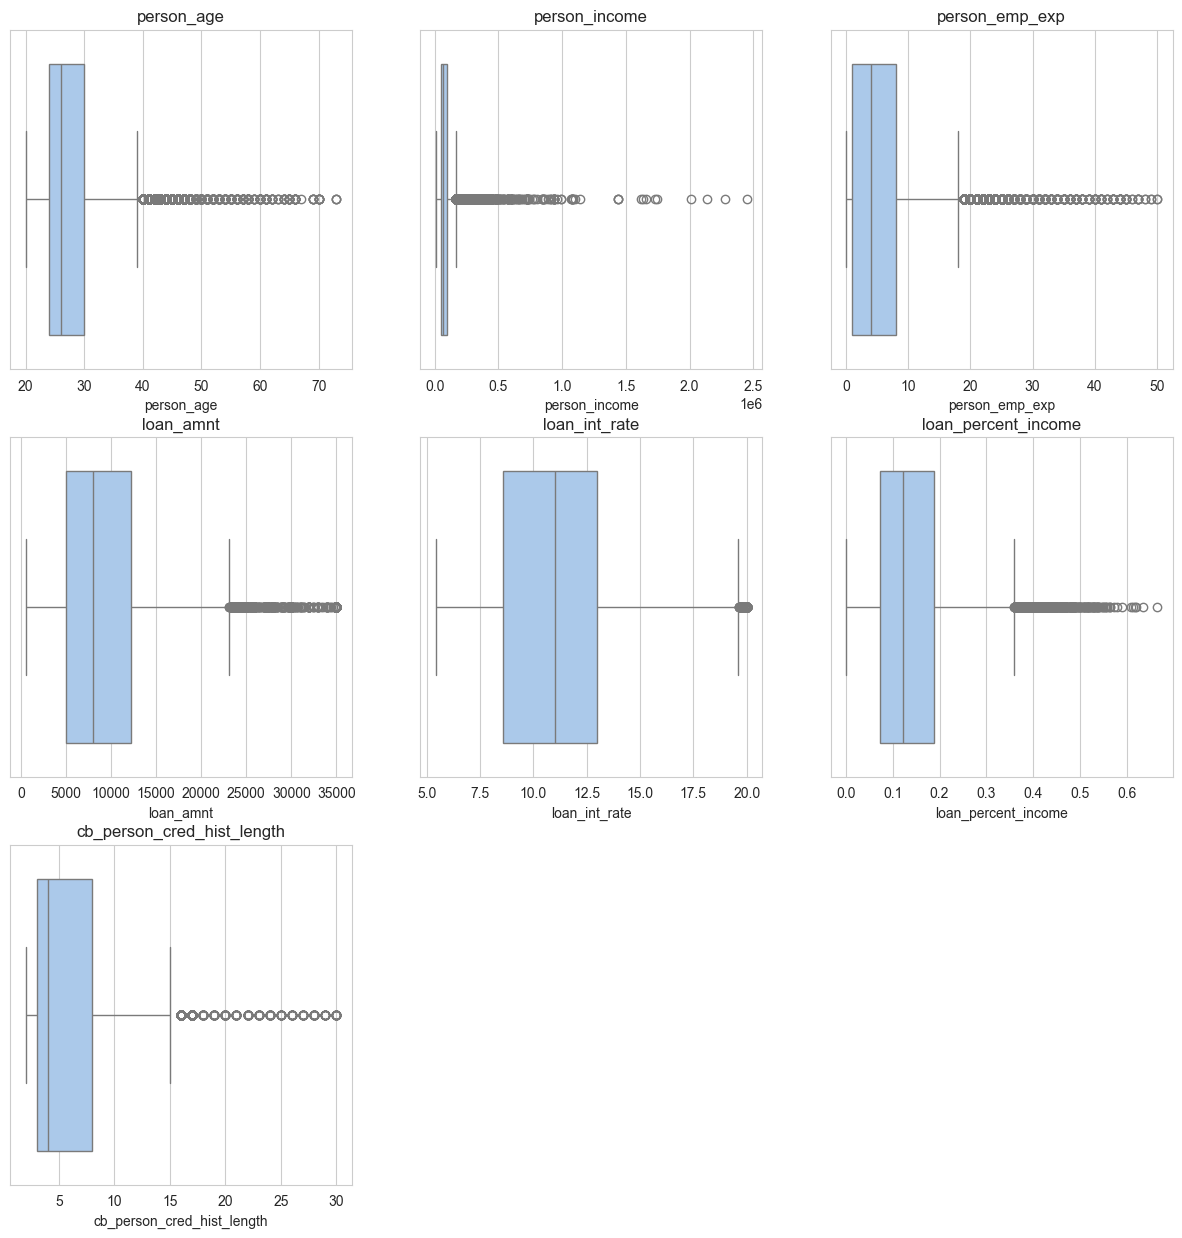

In [124]:
# Boxplot numerical columns 
plt.figure(figsize=(15,15))
for i,col in zip(range(1,len(n_column)),df[n_column]) : 
    plt.subplot(3,3,i)
    sns.boxplot(data = df , x=df[col])
    plt.title(col)
    plt.xlabel(col) 
plt.show()

- All numerical features have outliers.
- Maximum value of "person_age" and "person_emp_exp" are greater than 100, which is weird. This may due to data entry error. We need to do some pre-processing to correct the errors.

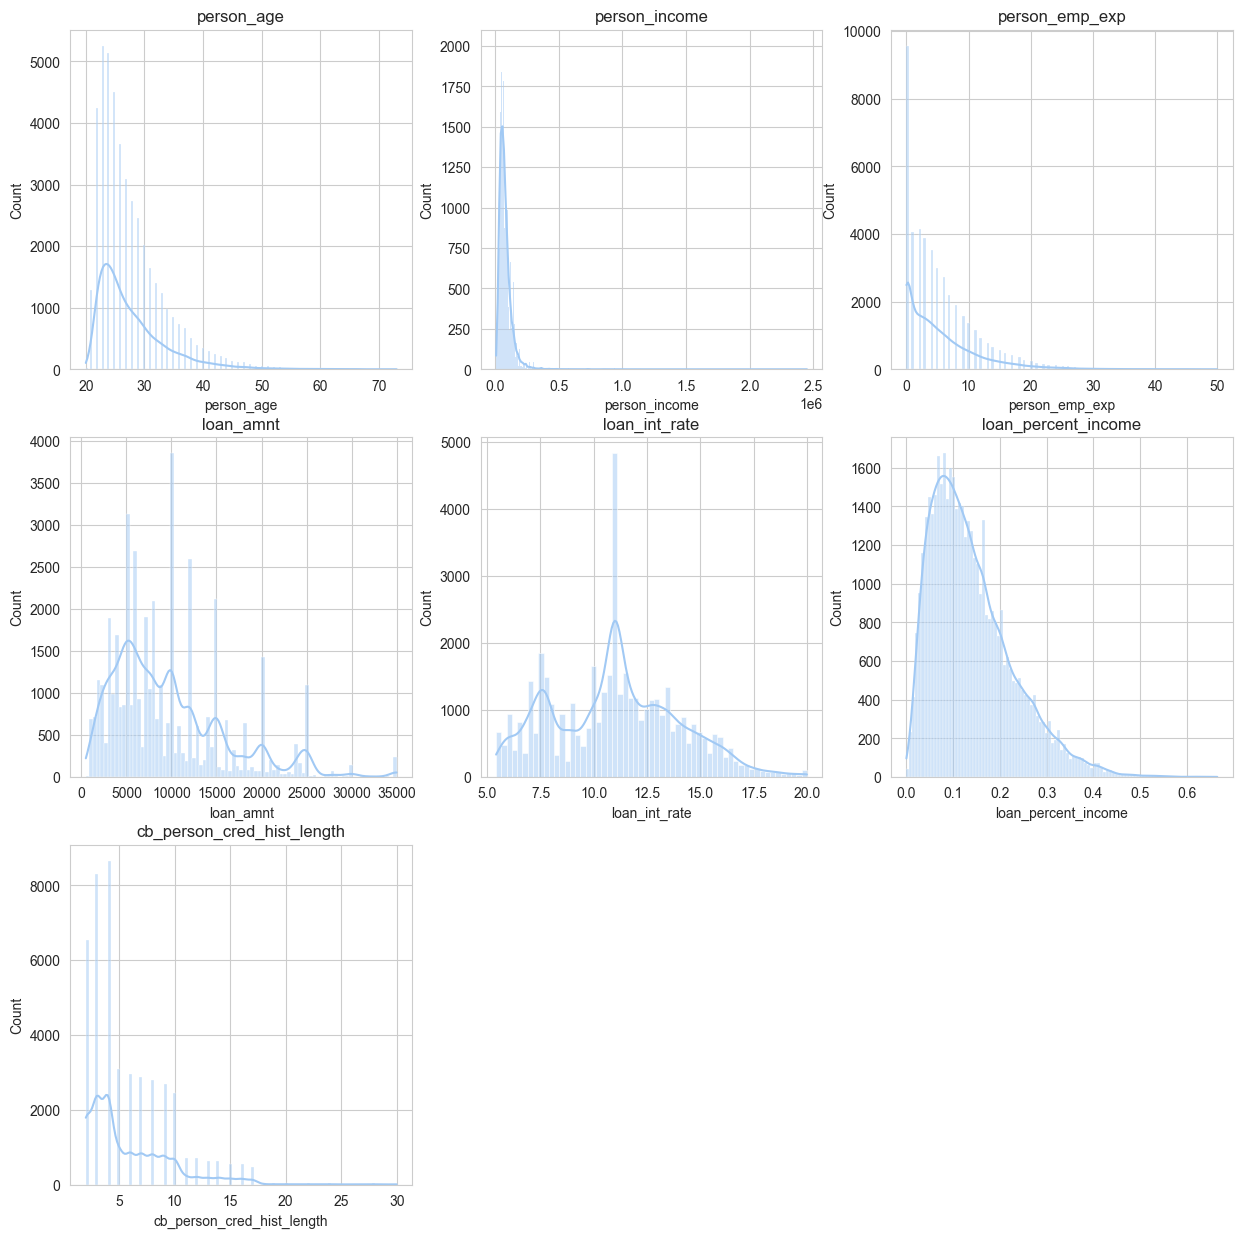

In [125]:
# Histogram
plt.figure(figsize=(15,15))
for i,col in zip(range(1,len(n_column)),df[n_column]):
    plt.subplot(3,3,i)
    sns.histplot(data=df, x=df[col],kde=True)
    plt.title(col)
    plt.xlabel(col)
plt.show()

We noticed that some features are rightly skewed which would need normalization before modelling.

In [126]:
# Detect Outliers
def detect_outliers(df, numerical_cols, lower_factor=1.5, upper_factor=1.5):
    outlier_data = pd.DataFrame()
    all_outliers_idx = set()  # Track indices of outliers

    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - lower_factor * IQR
        upper_bound = Q3 + upper_factor * IQR

        if not df.empty:
            print(f"{col}: Min Value = {df[col].min()}, Max Value = {df[col].max()}")
            print(f"{col}: Lower Bound = {lower_bound}, Upper Bound = {upper_bound}\n")

        outliers = df[(df[col] > upper_bound) | (df[col] < lower_bound)]
        all_outliers_idx.update(outliers.index)  # Store outlier indices
    
    # Separate outliers and cleaned data
    outlier_data = df.loc[list(all_outliers_idx)]
    df_cleaned = df.drop(index=all_outliers_idx)

    print("Outliers detected and stored in 'outlier_data'. Remaining data cleaned.")

    return df_cleaned, outlier_data

In [127]:
# Apply function
dfCleaned, outlierData = detect_outliers(df, n_column , 1.5 , 1.5)

person_age: Min Value = 20.0, Max Value = 73.0
person_age: Lower Bound = 15.0, Upper Bound = 39.0

person_income: Min Value = 8000.0, Max Value = 2448661.0
person_income: Lower Bound = -25682.875, Upper Bound = 168656.125

person_emp_exp: Min Value = 0, Max Value = 50
person_emp_exp: Lower Bound = -9.5, Upper Bound = 18.5

loan_amnt: Min Value = 500.0, Max Value = 35000.0
loan_amnt: Lower Bound = -5855.875, Upper Bound = 23093.125

loan_int_rate: Min Value = 5.42, Max Value = 20.0
loan_int_rate: Lower Bound = 1.9899999999999993, Upper Bound = 19.59

loan_percent_income: Min Value = 0.0006576120790186674, Max Value = 0.6641859720721802
loan_percent_income: Lower Bound = -0.09830339314875564, Upper Bound = 0.36001262199147316

cb_person_cred_hist_length: Min Value = 2.0, Max Value = 30.0
cb_person_cred_hist_length: Lower Bound = -4.5, Upper Bound = 15.5

credit_score: Min Value = 390, Max Value = 784
credit_score: Lower Bound = 497.5, Upper Bound = 773.5

Outliers detected and stored in 

In [128]:
# Validate total count
print(f"Cleaned Shape: {dfCleaned.shape[0]}")
print(f"Outlier Shape: {outlierData.shape[0]}")
print(f"Sum of Cleaned & Outliers: {dfCleaned.shape[0] + outlierData.shape[0]}")

Cleaned Shape: 37375
Outlier Shape: 7613
Sum of Cleaned & Outliers: 44988


In [129]:
# try to fix working exp/ ages that has data entry error
adjusted_data = outlierData[(outlierData["person_emp_exp"] > 60) | (outlierData["person_age"]>100)].copy() 
adjusted_data["person_emp_exp"] = adjusted_data["person_emp_exp"].apply(lambda x: x % 100 if x > 100 else 0)
adjusted_data["person_age"] = adjusted_data["person_age"].apply(lambda x: x % 100 if x > 120 else 0)

In [130]:
# Final data
myFinalData = pd.concat([dfCleaned,
                         adjusted_data[(adjusted_data['person_emp_exp']>0) & (adjusted_data['person_age']>0) ]]) 
myFinalData

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.081420,2.0,504,Yes,0
5,21.0,female,High School,12951.0,0,OWN,2500.0,VENTURE,7.14,0.193035,2.0,532,No,1
9,21.0,female,High School,12739.0,0,OWN,1600.0,VENTURE,14.74,0.125599,3.0,640,No,1
11,21.0,female,Associate,13113.0,0,OWN,4500.0,HOMEIMPROVEMENT,8.63,0.343171,2.0,651,No,1
19,24.0,female,Master,14283.0,1,MORTGAGE,1750.0,EDUCATION,10.99,0.122523,2.0,679,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44993,27.0,female,High School,35512.0,4,RENT,5000.0,PERSONAL,15.83,0.140797,5.0,505,No,1
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.312689,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.136778,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.048664,10.0,668,No,1


In [131]:
myFinalData.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,37375.000000,37375.000000,37375.000000,37375.000000,37375.000000,37375.000000,37375.000000,37375.000000,37375.000000
mean,26.613298,69787.316334,4.279438,8394.121873,10.898299,0.132986,5.170435,632.473712,0.210328
std,4.110490,31613.268332,4.137725,4852.325214,2.927546,0.075470,2.897503,47.675945,0.407547
min,20.000000,8000.000000,0.000000,500.000000,5.420000,0.006108,2.000000,498.000000,0.000000
25%,23.000000,45904.500000,1.000000,4812.000000,8.490000,0.074337,3.000000,601.000000,0.000000
50%,26.000000,64409.000000,3.000000,7500.000000,11.010000,0.119451,4.000000,639.000000,0.000000
75%,29.000000,88225.500000,7.000000,11500.000000,12.980000,0.179187,7.000000,668.000000,0.000000
max,39.000000,168633.000000,18.000000,23000.000000,19.530000,0.359971,15.000000,762.000000,1.000000


In [132]:
print("\nMissing values per column:")
print(myFinalData.isnull().sum())


Missing values per column:
person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64


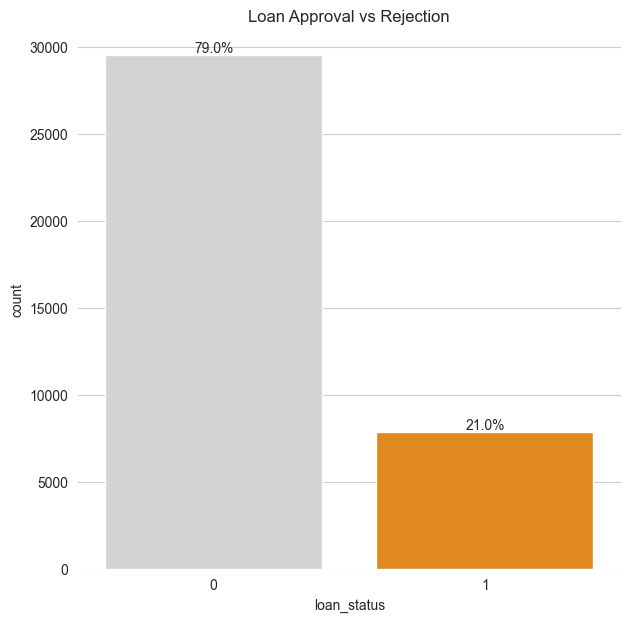

In [133]:
# visualize loan status
plt.figure(figsize = (7,7))

ax = sns.countplot(x = 'loan_status', data = myFinalData, palette = {'0': 'lightgrey', '1': 'darkorange'})
sns.despine(left = True, bottom = True)

# To display the percentage
total = len(myFinalData)

for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    x,y = p.get_xy()
    ax.text(x + width / 2, y + height, f'{height/total:.1%}', ha = 'center', va = 'bottom')

plt.title('Loan Approval vs Rejection')
plt.show()

Observing the values of loan approval status shows that the classes are imbalanced - there are far more rejected loan application than approved loan. This is important to note, we may need to balance the classes or apply cross-validation to improve model prediction accuracy.

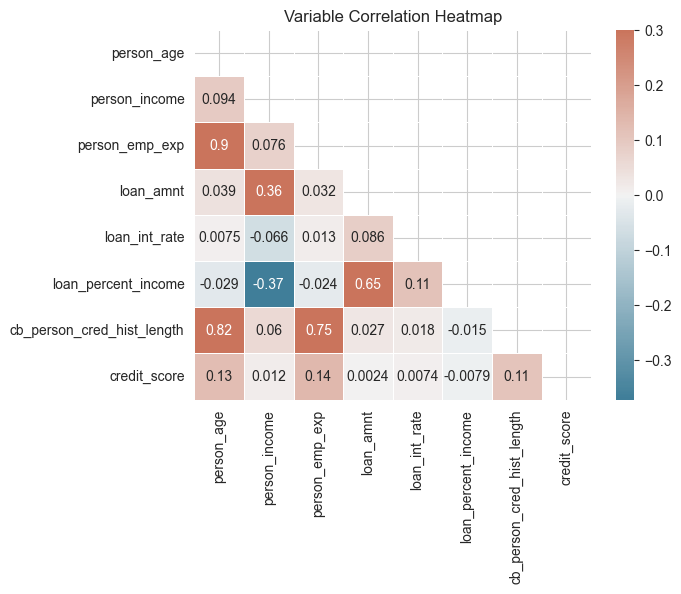

In [134]:
# correlation matrix
corr = myFinalData[n_column].corr()

# heatmap
plt.figsize = (11,11)

mask = np.triu(np.ones_like(corr, dtype = bool))
cmap = sns.diverging_palette(227, 21, as_cmap = True)

sns.heatmap(corr, annot=True, mask = mask, cmap = cmap, vmax = .3, center = 0, linewidths = 0.5)
plt.title('Variable Correlation Heatmap')
plt.show()

- Credit history grows with age and work experience. (expected)
- The loan-to-income ratio increases as the loan amount increases (income remain constant). A high loan amount relative to income might signal financial strain, which could impact loan approval.
- The higher the income, the lower the percentage of income the loan represents. Applicants with higher incomes appear less risky in terms of repayment burden

C:\Users\Loong\AppData\Local\Temp\ipykernel_24492\1610932414.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 25, ha = 'right')
C:\Users\Loong\AppData\Local\Temp\ipykernel_24492\1610932414.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 25, ha = 'right')
C:\Users\Loong\AppData\Local\Temp\ipykernel_24492\1610932414.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 25, ha = 'right')
C:\Users\Loong\AppData\Local\Temp\ipykernel_24492\1610932414.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


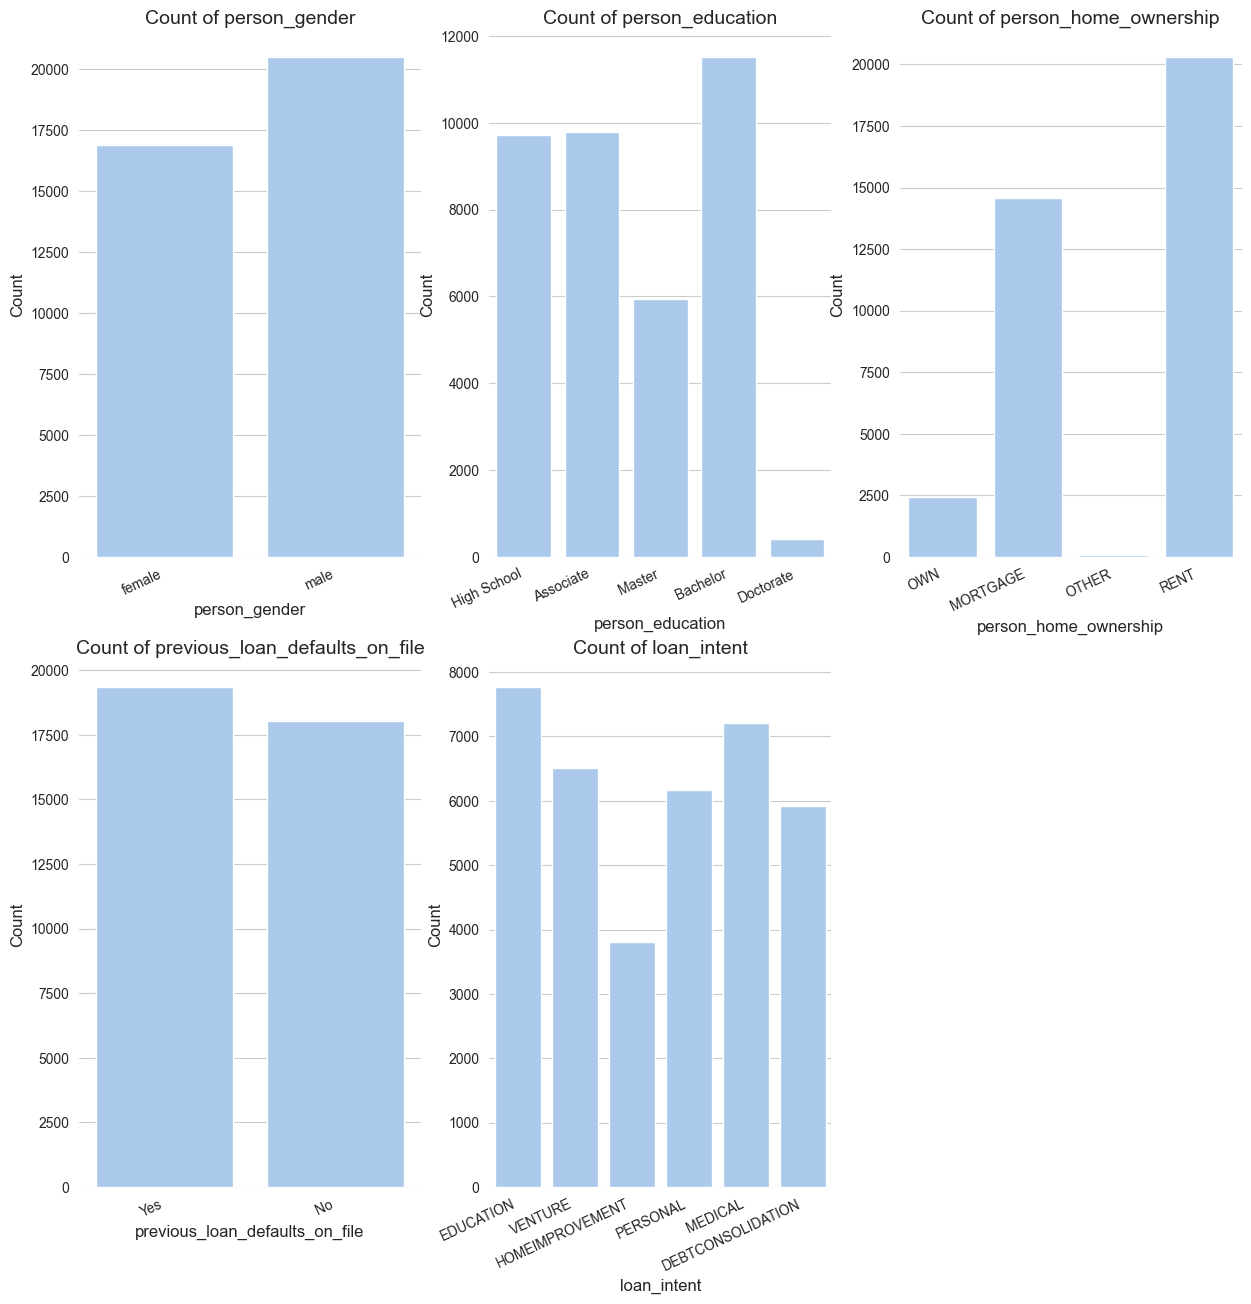

In [135]:
# categorical features bivariate analysis
# visualisation grid
sns.set_style("whitegrid")
sns.set_palette("pastel")

plt.figure(figsize=(15,15))
for i,col in zip(range(1,len(c_column)+1),myFinalData[c_column]):
    ax = plt.subplot(2,3,i)

    sns.countplot(data=myFinalData, x=myFinalData[col])
    sns.despine(left = True, bottom = True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 25, ha = 'right')
    ax.legend_ = None

    plt.title(f"Count of {col}", fontsize=14) 
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Count", fontsize=12)

plt.show()

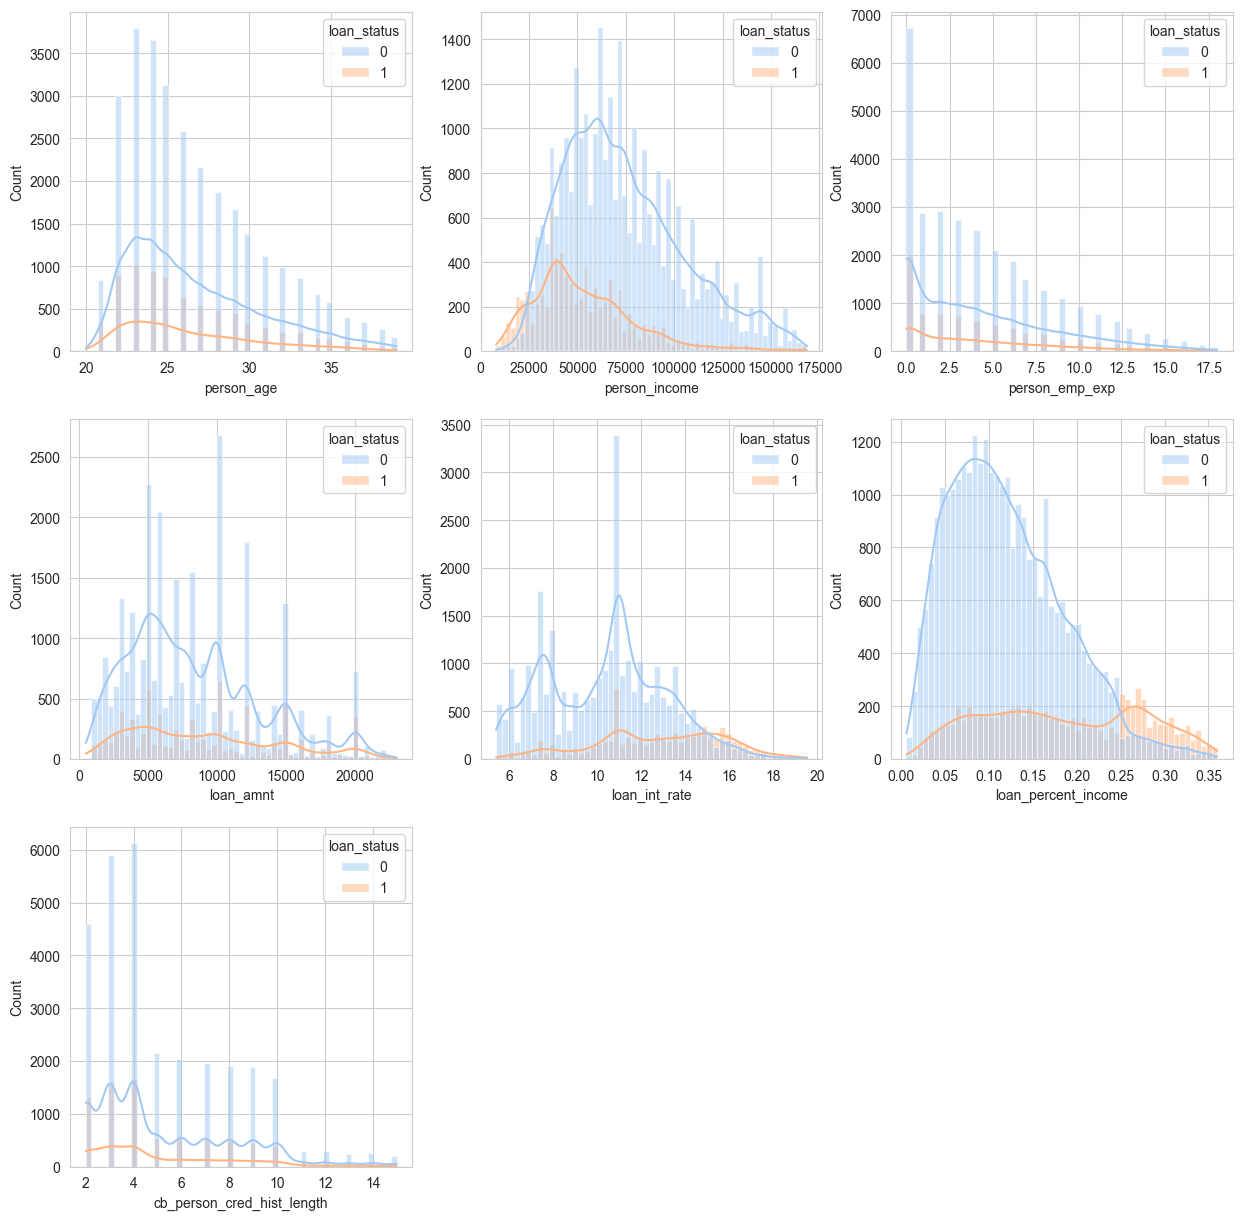

In [136]:
# numerical feature bivariate analysis
# visualisation grid
# Histogram
plt.figure(figsize=(15,15))
for i,col in zip(range(1,len(n_column)),myFinalData[n_column]):
    plt.subplot(3,3,i)
    sns.histplot(data=myFinalData, x=myFinalData[col],hue= 'loan_status',kde=True)
plt.show()

- Most of applicants between 21-26 years old.
- Surprisingly, loan approval rate increases for loan percent income > 25%

In [137]:
# save myFinalData
myFinalData.to_csv('data/myFinalData.csv', index=False)

## 4. Data Preprocessing

This section will include steps like handling missing values, encoding categorical variables, and scaling the data. The goal is to prepare the data for modeling.

In [138]:
# shows the missing value
missing_values = myFinalData.isnull().sum()
missing_values = missing_values[missing_values > 0]

print("Missing values in the dataset:")
print(missing_values)

Missing values in the dataset:
Series([], dtype: int64)


No missing values found in all columns. 

In [139]:
# shows unique value of categorical columns
print("\nUnique values in categorical columns:")
for col in myFinalData.select_dtypes(include=['object']).columns:
    unique_values = myFinalData[col].unique()
    print(f"{col}: {len(unique_values)} unique values")
    print(unique_values[:5])  # show only the first 5 unique values
    print()


Unique values in categorical columns:
person_gender: 2 unique values
['female' 'male']

person_education: 5 unique values
['High School' 'Associate' 'Master' 'Bachelor' 'Doctorate']

person_home_ownership: 4 unique values
['OWN' 'MORTGAGE' 'OTHER' 'RENT']

loan_intent: 6 unique values
['EDUCATION' 'VENTURE' 'HOMEIMPROVEMENT' 'PERSONAL' 'MEDICAL']

previous_loan_defaults_on_file: 2 unique values
['Yes' 'No']



We can see that the categorical variables are stated in words, so we need to convert them into numbers. We can use the `LabelEncoder` from `sklearn` to do this.

In [140]:
# Encode the categorical variables
from sklearn.preprocessing import LabelEncoder

# Create a copy of the DataFrame to avoid modifying the original data
df_encoded = myFinalData.copy()

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode each categorical column
for col in c_column:
    df_encoded[col] = label_encoder.fit_transform(df_encoded[col])

# Display the first few rows of the encoded DataFrame
df_encoded.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
1,21.0,0,3,12282.0,0,2,1000.0,1,11.14,0.081420,2.0,504,1,0
5,21.0,0,3,12951.0,0,2,2500.0,5,7.14,0.193035,2.0,532,0,1
9,21.0,0,3,12739.0,0,2,1600.0,5,14.74,0.125599,3.0,640,0,1
11,21.0,0,0,13113.0,0,2,4500.0,2,8.63,0.343171,2.0,651,0,1
19,24.0,0,4,14283.0,1,0,1750.0,1,10.99,0.122523,2.0,679,0,1


We can see that the data is being encoded into numbers. But wait, how can we reference back which code is refer to which category? We can just map each of the category back.

In [141]:
# show nan values
print("\nNaN values in the dataset:")
print(df_encoded.isna().sum())  # Changed isnan() to isna()


NaN values in the dataset:
person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64


In [142]:
# Show encoding mapping for each categorical column
for col in c_column:
    label_encoder.fit(myFinalData[col])
    print(f"Encoding for '{col}':")
    for idx, class_ in enumerate(label_encoder.classes_):
        print(f"  {idx}: {class_}")
    print()

Encoding for 'person_gender':
  0: female
  1: male

Encoding for 'person_education':
  0: Associate
  1: Bachelor
  2: Doctorate
  3: High School
  4: Master

Encoding for 'person_home_ownership':
  0: MORTGAGE
  1: OTHER
  2: OWN
  3: RENT

Encoding for 'previous_loan_defaults_on_file':
  0: No
  1: Yes

Encoding for 'loan_intent':
  0: DEBTCONSOLIDATION
  1: EDUCATION
  2: HOMEIMPROVEMENT
  3: MEDICAL
  4: PERSONAL
  5: VENTURE



We can see that the mapping dictionary is created. We can use this to reference back the original category. Next, most of the numerical features comes with different scales. We need to scale them to the same scale. We can use the `StandardScaler` from `sklearn` to do this.

In [143]:
# Fix the scaling process to avoid NaN values
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Step 1: Load the data
myFinalData = pd.read_csv('data/myFinalData.csv')

# Step 2: Encode categorical columns first
df_encoded = myFinalData.copy()
label_encoder = LabelEncoder()

for col in c_column:
    df_encoded[col] = label_encoder.fit_transform(df_encoded[col])

# Step 3: Scale numerical features
scaler = StandardScaler()
scaled_columns = ["person_age", "person_income", "person_emp_exp", "loan_amnt",
                "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length",
                "credit_score"]
                
scaled_data = scaler.fit_transform(df_encoded[scaled_columns])

# Step 4: Create DataFrame with scaled data
scaled_df = pd.DataFrame(scaled_data, columns=scaled_columns)

# Step 5: Concatenate with the encoded categorical columns
df_scaled = pd.concat([df_encoded.drop(columns=scaled_columns), scaled_df], axis=1)

# Step 6: Verify no NaN values
print("\nNaN values in the dataset:")
print(df_scaled.isna().sum())


NaN values in the dataset:
person_gender                     0
person_education                  0
person_home_ownership             0
loan_intent                       0
previous_loan_defaults_on_file    0
loan_status                       0
person_age                        0
person_income                     0
person_emp_exp                    0
loan_amnt                         0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
dtype: int64


## 5. Modelling

This section will include steps like splitting, data balancing, and prepare the data into training and testing sets, training the model, and evaluating the model. The goal is to build a model that can predict the target variable accurately.

The dataset is splitted into 80% training data and 20% test data for all the model.

In [144]:
# Train and Test Split
from sklearn.model_selection import train_test_split

# Split the data into features and target variable
X = df_scaled.drop(columns=['loan_status'])
y = df_scaled['loan_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the training and testing sets
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (29900, 13)
Testing set shape: (7475, 13)


In [145]:
# Check the distribution of target variable of the training sets
print(f"Training set shape: {y_train.value_counts()}")

Training set shape: loan_status
0    23568
1     6332
Name: count, dtype: int64


As mentioned above, the data is imbalanced. Synthetic Minority Over-sampling Technique for Nominal and Continuous (SMOTENC) is used for balancing the training dataset as this technique suitable for dataset that containing numerical and categorical features.

In [146]:
from imblearn.over_sampling import SMOTENC

# Identify categorical columns for SMOTENC 
categorical_cols = [
    "person_gender",
    "person_education",
    "person_home_ownership",
    "loan_intent",
    "previous_loan_defaults_on_file",
]

# SMOTE needs categorical columns as indices for non-continuous features
categorical_indices = [X.columns.get_loc(col) for col in categorical_cols]

# Apply SMOTE
smote = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_resampled_train, y_resampled_train = smote.fit_resample(X_train,y_train)

# Check the distribution of target variable of the resampled training set
print(f"Training set shape: {y_resampled_train.value_counts()}")

Training set shape: loan_status
0    23568
1    23568
Name: count, dtype: int64


The machine learning methods that will be used for modelling are follows:
- Logistic Regression
- Decision Tree
- Random Forest
- Support Vector Machine
- Gaussian Naive Bayes

In [147]:
# Import the necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

Logistic Regression

Logistic Regression is an algorithm used for classification tasks to predict the probability that an instance belongs to a given class or not. 

In [148]:
# Train, fit and predict using the base model
logreg = LogisticRegression(random_state=42)
logreg.fit(X_resampled_train, y_resampled_train)
logreg_pred = logreg.predict(X_test)

Decision Tree

Decision Tree is a machine learning method by predicts the value of a target variable by learning simple decision rules inferred from the data features.

In [149]:
# Train, fit and predict using the base model
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_resampled_train, y_resampled_train)
dtc_pred = dtc.predict(X_test)

Random Forest

Random Forest is a machine learning algorithm that combines the output of multiple decision trees to make predictions.

In [150]:
# Train, fit and predict using the base model
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_resampled_train, y_resampled_train)
rfc_pred = rfc.predict(X_test)

# Save the model as pkl in model directory
import os
import joblib

# Create directory if it doesn't exist
os.makedirs('model', exist_ok=True)

# Now save the file
joblib.dump(rfc, 'model/random_forest_model.pkl')

['model/random_forest_model.pkl']

Support Vector Machine (SVM)

SVM is a machine learning method to find the optimal line, called hyperplane in an N-dimensional space to separate data points into different classes.

In [151]:
# Train, fit and predict using the base model
svm = SVC(random_state=42)
svm.fit(X_resampled_train, y_resampled_train)
svm_pred = svm.predict(X_test)

Gaussian Naive Bayes

Gaussian Naive Bayes is a classification technique in machine learning where features are assumed to follow Gaussian distribution.

In [152]:
# Train, fit and predict using the base model
gnb = GaussianNB()
gnb.fit(X_resampled_train, y_resampled_train)
gnb_pred = gnb.predict(X_test)

Hyperparameter Tuning

Hyperparameter tuning using Grid Search is implemented to optimize the model performance. Grid Search is a technique identifying the optimal parameters from a given set of parameters in a grid in machine learning. 5-fold cross validation is chosen to use to generalize effectively to unseen data and reduce the risk of overfitting.

Parameter of Logistic Regression
- C: Inverse of regularization strength to prevent overfitting or underfitting. Smaller values of C specify stronger regularization *(Default: 1.0)*
- penalty: Regularization technique *(Default: l2)*
- solver: Algorithm to use in the optimization problem. The choice of the algorithm depends on the penalty chosen *(Default: lbfgs)*
- max_iter: Maximum number of iterations taken for the solvers to converge *(Default: 100)*
- l1_ratio: Parameter for penalty of elasticnet between value 0 and 1 *(Default: None)*

In [153]:
# Define the parameter grid
param_grid = [
    # Group 1: Solvers that support 'l2' penalty 
    {
        'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],
        'penalty': ['l2'], 
        'C': [0.1, 1, 10, 100],
        'max_iter': [100, 200, 500]
    },
    # Group 2: Solver 'saga' which supports both 'l1' and 'l2'
    {
        'solver': ['saga'],
        'penalty': ['l1', 'l2','elasticnet'], 
        'C': [0.1, 1, 10, 100],
        'max_iter': [100, 200, 500],
        'l1_ratio': [0.1, 0.5, 0.9]  # Only for 'elasticnet'
    }
]

# Perform GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the grid search to the training data
grid_search.fit(X_resampled_train, y_resampled_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters found
print(f"Best hyperparameters: {best_params}")

Fitting 5 folds for each of 156 candidates, totalling 780 fits
Best hyperparameters: {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


Parameter of Decision Tree
- max_depth: The maximum number of levels allowed in the tree *(Default: None)*
- min_samples_leaf: The minimum number of samples required to be at a leaf node *(Default: 1)*
- min_samples_split: The minimum number of samples required to split an internal node *(Default: 2)*

In [154]:
# Define the parameter grid
param_grid = {
    'max_depth': [None,10,20],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

# Perform GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters found
print(f"Best hyperparameters: {best_params}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}


Parameter of Random Forest
- n_estimators: The number of trees in the forest *(Default: 100)*
- max_depth: The maximum number of levels allowed in each tree in the forest *(Default: None)*
- criterion: The function to measure the quality of a split *(Default: gini)*
- min_samples_leaf: The minimum number of samples required to be at a leaf node in each tree *(Default: 1)*
- min_samples_split: The minimum number of samples required to split an internal node in each tree *(Default: 2)*

In [155]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50,100,200],  
    'max_depth': [None,10,20],
    'criterion': ['gini', 'entropy','log_loss'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

# Perform GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the grid search to the training data
grid_search.fit(X_resampled_train, y_resampled_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters found
print(f"Best hyperparameters: {best_params}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


Parameter of SVM
- C: Inverse of regularization strength *(Default: 1.0)*
- kernel: Kernel type to be used in the algorithm *(Default: rbf)*

In [156]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly']
}

# Perform GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, 
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_resampled_train, y_resampled_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters found
print(f"Best hyperparameters: {best_params}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters: {'C': 100, 'kernel': 'rbf'}


Parameter of Gaussian Naive Bayes
- var_smoothing: Value added to all predictor variances for calculation stability *(Default: 1e-9)*

In [157]:
# Define the hyperparameter grid
param_grid = {
    'var_smoothing':[1e-3, 1e-6, 1e-9, 1e-12, 1e-15],
}

# Perform GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, 
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_resampled_train, y_resampled_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters found
print(f"Best hyperparameters: {best_params}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best hyperparameters: {'var_smoothing': 0.001}


## 6. Evaluation

This section will include steps like evaluating the model using various metrics, such as accuracy, precision, recall, and F1 score. The goal is to understand how well the model performs on the test data.

In [158]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Instantiate tuned models with best hyperparameters
logreg_tuned = LogisticRegression(C=100, max_iter=100, penalty='l2', solver='lbfgs', random_state=42)
logreg_tuned.fit(X_resampled_train, y_resampled_train)

dtc_tuned = DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=2, random_state=42)
dtc_tuned.fit(X_resampled_train, y_resampled_train)

rfc_tuned = RandomForestClassifier(criterion='entropy', max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=42)
rfc_tuned.fit(X_resampled_train, y_resampled_train)

svm_tuned = SVC(C=100, kernel='rbf', random_state=42)
svm_tuned.fit(X_resampled_train, y_resampled_train)

gnb_tuned = GaussianNB(var_smoothing=0.001)
gnb_tuned.fit(X_resampled_train, y_resampled_train)

# Dictionary of models for evaluation
models = {
    "Logistic Regression (Baseline)": logreg,
    "Logistic Regression (Tuned)": logreg_tuned,
    "Decision Tree (Baseline)": dtc,
    "Decision Tree (Tuned)": dtc_tuned,
    "Random Forest (Baseline)": rfc,
    "Random Forest (Tuned)": rfc_tuned,
    "SVM (Baseline)": svm,
    "SVM (Tuned)": svm_tuned,
    "GaussianNB (Baseline)": gnb,
    "GaussianNB (Tuned)": gnb_tuned,
}

# Evaluate all models
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, zero_division=0))
    print("Recall:", recall_score(y_test, y_pred, zero_division=0))
    print("F1 Score:", f1_score(y_test, y_pred, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))


Logistic Regression (Baseline)
Accuracy: 0.8494983277591973
Precision: 0.5831275720164609
Recall: 0.9267495094833225
F1 Score: 0.7158373326597626
Confusion Matrix:
 [[4933 1013]
 [ 112 1417]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.83      0.90      5946
           1       0.58      0.93      0.72      1529

    accuracy                           0.85      7475
   macro avg       0.78      0.88      0.81      7475
weighted avg       0.90      0.85      0.86      7475


Logistic Regression (Tuned)
Accuracy: 0.8494983277591973
Precision: 0.5831275720164609
Recall: 0.9267495094833225
F1 Score: 0.7158373326597626
Confusion Matrix:
 [[4933 1013]
 [ 112 1417]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.83      0.90      5946
           1       0.58      0.93      0.72      1529

    accuracy                           0.85      7475
   macro avg       0.78 

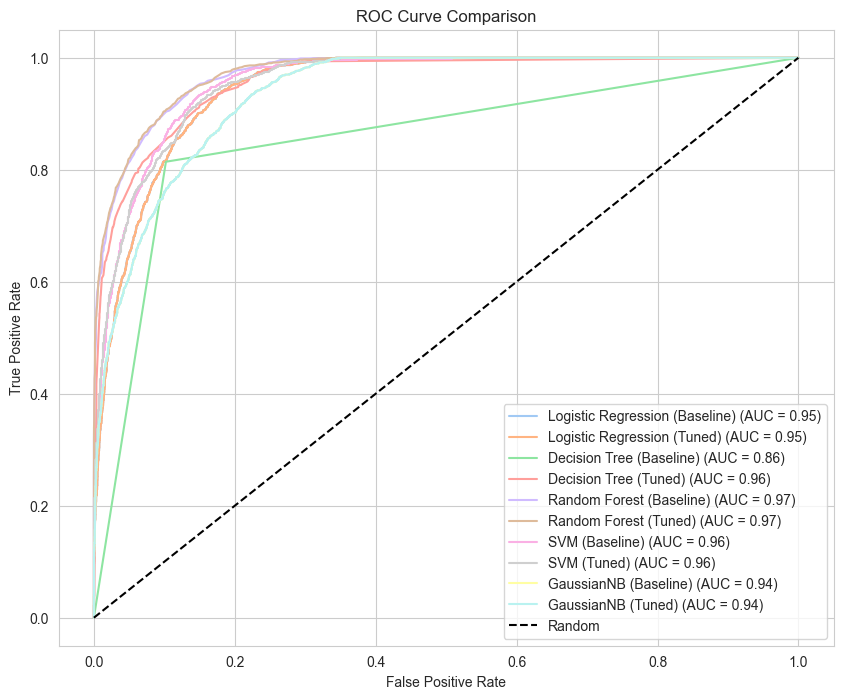

In [159]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

for name, model in models.items():
    # Some models use predict_proba, some use decision_function
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        continue  # Skip if neither is available

    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc = roc_auc_score(y_test, y_score)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

### Feature Importance Analysis (Accuracy Impact)
Tree-based models (Random Forest, Decision Tree) have .feature_importances_ attribute. <br>
For Logistic Regression, use the absolute value of coefficients. <br>
For linear SVM, feature importance can be interpreted from the absolute value of the coefficients. For non-linear kernels (e.g., RBF, in this case), feature importance is not directly available.<br>
For Gaussian Naive Bayes, There is no direct feature importance attribute.

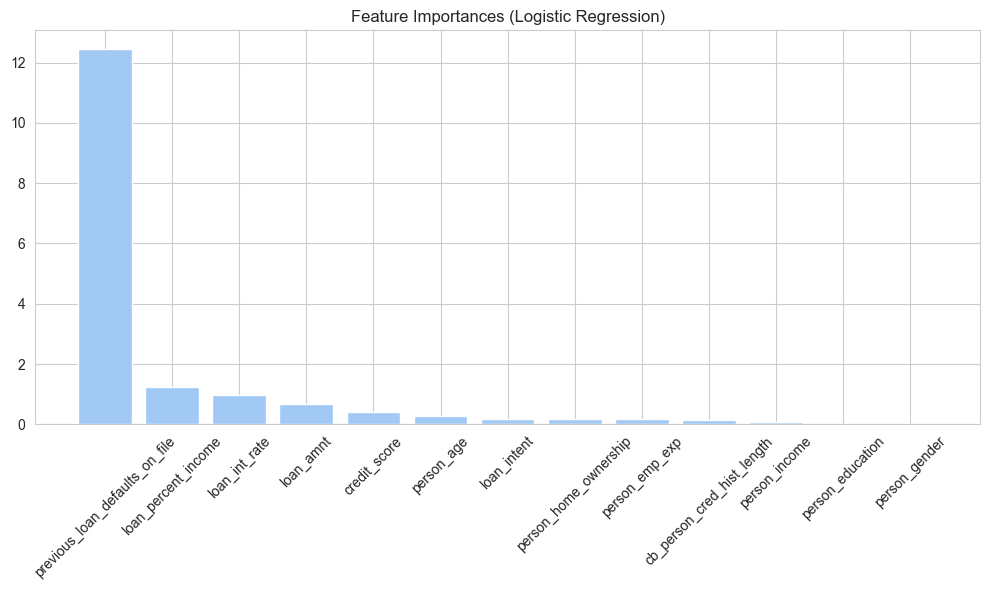

In [161]:
# Feature importance for Logistic Regression (absolute value of coefficients)
coefs = np.abs(logreg_tuned.coef_[0])
indices = np.argsort(coefs)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importances (Logistic Regression)")
plt.bar(range(len(coefs)), coefs[indices], align="center")
plt.xticks(range(len(coefs)), feature_names[indices], rotation=45)
plt.tight_layout()
plt.show()

The feature importance plot for Logistic Regression visually ranks the input features based on the absolute values of their coefficients, indicating how strongly each feature influences the model’s loan approval predictions. Features with larger bars have a greater impact on the model’s decision-making process, while those with smaller bars contribute less.

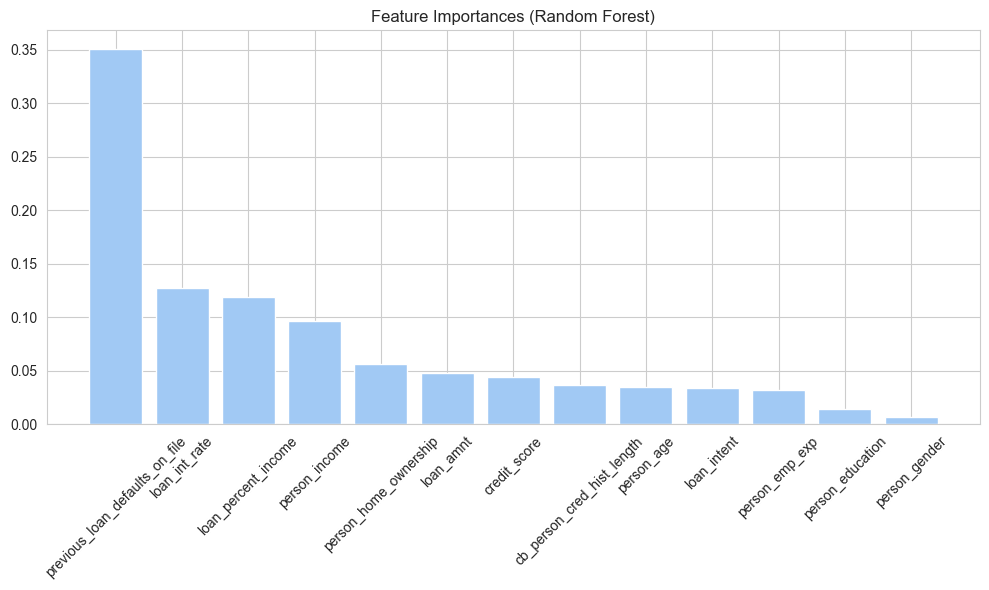

In [160]:
# Feature importance for Random Forest
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get feature names (make sure X_train is a DataFrame)
feature_names = X_train.columns
importances = rfc_tuned.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=45)
plt.tight_layout()
plt.show()

The feature importance plot for the Random Forest model displays the relative contribution of each input feature to the model’s loan approval predictions. Features with longer bars are considered more important, as they have a greater influence on the model’s decision-making process. 

### Fairness Assessment (by Group)

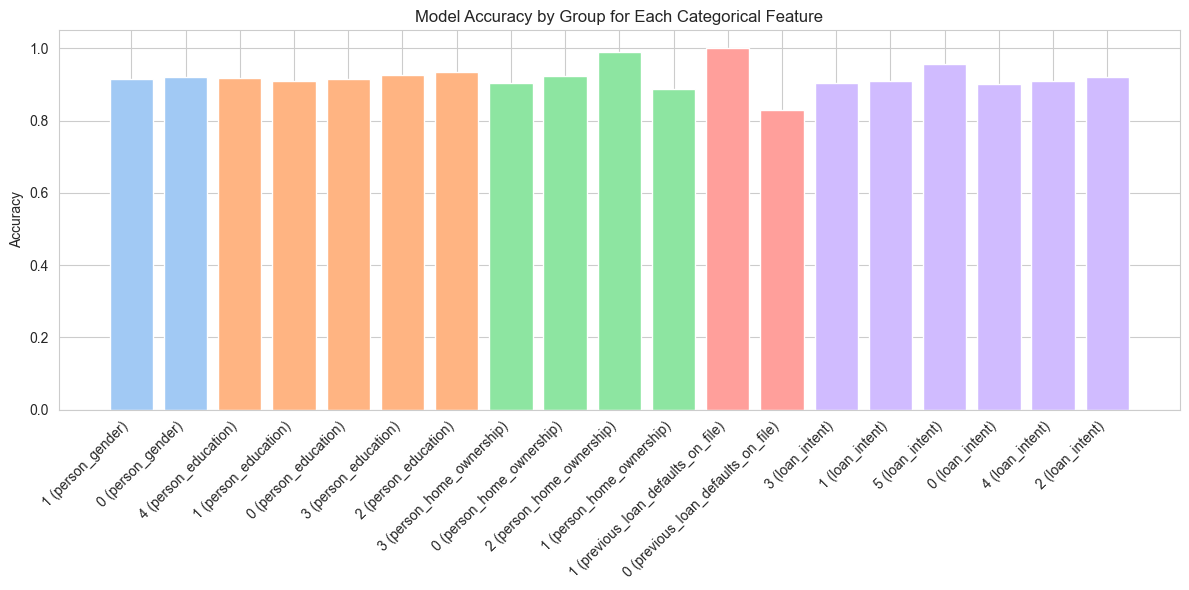

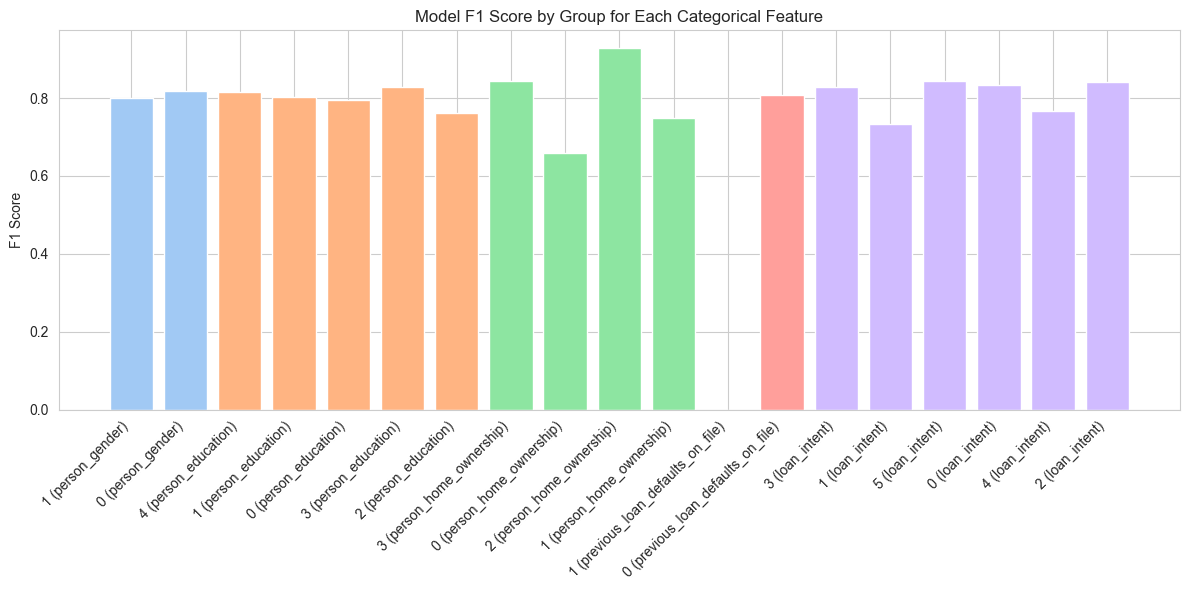

In [163]:
# Fairness assessment for categorical features
# List of categorical features to assess fairness
categorical_features = ["person_gender", "person_education", "person_home_ownership", 
                        "previous_loan_defaults_on_file", "loan_intent"]

# Store results
fairness_results = []

for feature in categorical_features:
    for value in X_test[feature].unique():
        idx = X_test[feature] == value
        y_true = y_test[idx]
        y_pred = rfc_tuned.predict(X_test[idx])
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        fairness_results.append({
            "Feature": feature,
            "Group": value,
            "Accuracy": acc,
            "F1 Score": f1,
            "Count": len(y_true)
        })

# Convert to DataFrame
fairness_df = pd.DataFrame(fairness_results)

# Visualize: Accuracy by group for each feature
plt.figure(figsize=(12, 6))
for feature in categorical_features:
    subset = fairness_df[fairness_df["Feature"] == feature]
    plt.bar(subset["Group"].astype(str) + f" ({feature})", subset["Accuracy"], label=feature)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.title("Model Accuracy by Group for Each Categorical Feature")
plt.tight_layout()
plt.show()

# Visualize: F1 Score by group for each feature
plt.figure(figsize=(12, 6))
for feature in categorical_features:
    subset = fairness_df[fairness_df["Feature"] == feature]
    plt.bar(subset["Group"].astype(str) + f" ({feature})", subset["F1 Score"], label=feature)
plt.xticks(rotation=45, ha='right')
plt.ylabel("F1 Score")
plt.title("Model F1 Score by Group for Each Categorical Feature")
plt.tight_layout()
plt.show()

The plots provide valuable insights into how the model performs across different groups within each categorical feature, such as gender, education level, home ownership, previous loan defaults, and loan intent. By examining the accuracy and F1 score for each group, it is possible to determine whether the model is making predictions fairly and consistently. Significant differences in performance between groups may indicate potential bias or unfairness, suggesting that the model favors certain groups over others. Additionally, the plots can highlight underrepresented groups, where the model may struggle due to limited data. Overall, these visualizations assist in assessing both the accuracy and fairness of the model, guiding informed decisions about addressing any disparities and improving model equity.